# Surface Code Encoding

In [12]:
import matplotlib.pyplot as plt
import json
from qiskit import QuantumCircuit, transpile, QuantumRegister, ClassicalRegister, assemble
from qiskit_aer import Aer, AerSimulator
from qiskit_ibm_runtime import QiskitRuntimeService, SamplerV2, Session, SamplerOptions
from qtcodes import XXZZQubit
import time
import numpy as np
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.metrics import classification_report, accuracy_score
from scipy.stats import mode
import logging
import asyncio
import pickle

In [13]:
global api_token, service, backends
api_token = 'be5e713d2a8fa9228e96fbb61a84af3337e4730a2d7a174eaeeb8c625f964b516a29f367490a0fa50ec5de4dff1be879e018c6f87e906a15b379519049c9868a'

In [14]:
service = QiskitRuntimeService(channel="ibm_quantum", token=api_token)

In [15]:
for job in service.jobs():
    print(job.tags, job.status().name)

['qubit1Z_d3_ibm_brisbane'] DONE
['qubit1Z_d3_ibm_brisbane'] CANCELLED
['qubit1Z_d3_ibm_sherbrooke'] DONE
['qubit1Z_d3_ibm_kyiv'] DONE
['qubit1Z_d3_ibm_brisbane'] CANCELLED
['qubit1Z_d5_ibm_kyiv'] DONE
['qubit1Z_d5_ibm_sherbrooke'] DONE
['qubit1Z_d5_ibm_brisbane'] DONE
['qubit1Z_async_ibm_kyiv'] DONE
['qubit1Z_async_ibm_sherbrooke'] DONE


In [4]:
with open('qubit1Z_d5_state.pkl', 'rb') as f:
    qubit = pickle.load(f)

In [1]:
%load_ext autoreload
%autoreload 2

In [12]:
from qiskit import QuantumCircuit, execute, QuantumRegister, ClassicalRegister, Aer
import matplotlib.pyplot as plt

## Stabilizer Eigenstates

Following Fowler et. al [1], we see that the two-qubit operators $Z_a Z_b$ commute with $X_a X_b$. The eigenstates of these *stabilizers* are the Bell states (**Table II**):

<p align="center">
<img width="245" alt="stabilizer-eigenstates" src="https://user-images.githubusercontent.com/293681/88832601-0f9a5800-d19f-11ea-88fe-a8191e21a67e.png">
</p>

[1] Fowler, A. G., Mariantoni, M., Martinis, J. M. & Cleland, A. N. Surface codes: Towards practical large-scale quantum computation. Phys. Rev. A 86, 032324 (2012).


/Users/devon/anaconda3/lib/python3.11/site-packages/qiskit/visualization/circuit/matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


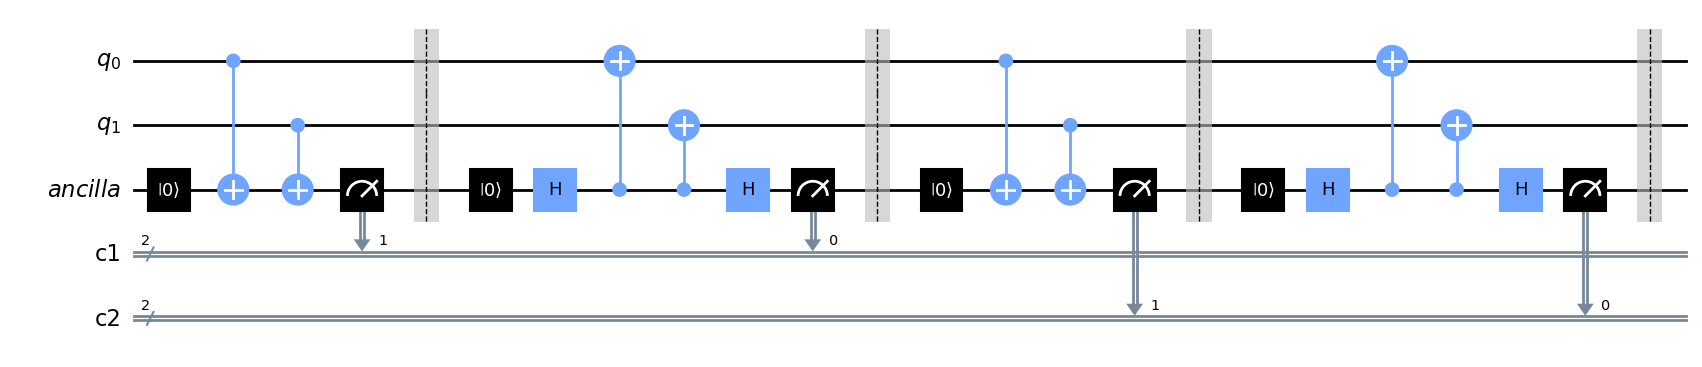

In [3]:
qr = QuantumRegister(2, name='q')
an = QuantumRegister(1, name='ancilla')

rounds = 2
measurements = [ClassicalRegister(2, name="c{}".format(i+1)) for i in range(rounds)]

circ = QuantumCircuit(qr, an, *measurements)

# Check for ZZ parity of 2 qubits
def ZZ_meas(round):
    circ.reset(an)
    circ.cx(0, 2)
    circ.cx(1, 2)
    circ.measure(an, measurements[round][1])
    circ.barrier()

# Check for XX parity of 2 qubits
def XX_meas(round):
    circ.reset(an)
    circ.h(an)
    circ.cx(an, 0)
    circ.cx(an, 1)
    circ.h(an)
    circ.measure(an, measurements[round][0])
    circ.barrier()

for i in range(rounds):
    ZZ_meas(i)
    XX_meas(i)

circ.draw(output='mpl', fold=35)

Running this circuit on the four Bell states, and the stabilizer is stable:

/var/folders/k3/27w60qks2nn1dv0q05k_30z40000gn/T/ipykernel_21077/2612265259.py:6: DeprecationWarning: The method ``qiskit.circuit.quantumcircuit.QuantumCircuit.i()`` is deprecated as of qiskit 0.45.0. It will be removed in the Qiskit 1.0.0 release. Use QuantumCircuit.id as direct replacement.
  getattr(test_circ, q0_gate)(0) #i.e. test_circ.i(0) or test_circ.x(0)
/var/folders/k3/27w60qks2nn1dv0q05k_30z40000gn/T/ipykernel_21077/2612265259.py:7: DeprecationWarning: The method ``qiskit.circuit.quantumcircuit.QuantumCircuit.i()`` is deprecated as of qiskit 0.45.0. It will be removed in the Qiskit 1.0.0 release. Use QuantumCircuit.id as direct replacement.
  getattr(test_circ, q1_gate)(1) #i.e. test_circ.i(1) or test_circ.x(1)
/var/folders/k3/27w60qks2nn1dv0q05k_30z40000gn/T/ipykernel_21077/2612265259.py:15: DeprecationWarning: The 'qiskit.Aer' entry point is deprecated and will be removed in Qiskit 1.0. You should use 'qiskit_aer.Aer' directly instead.
  print("Bell state %s%s:" % (q0_gate

Bell state ii: {'00 00': 1}
Bell state ix: {'10 10': 1}
Bell state xi: {'01 01': 1}
Bell state xx: {'11 11': 1}


/var/folders/k3/27w60qks2nn1dv0q05k_30z40000gn/T/ipykernel_21077/2612265259.py:6: DeprecationWarning: The method ``qiskit.circuit.quantumcircuit.QuantumCircuit.i()`` is deprecated as of qiskit 0.45.0. It will be removed in the Qiskit 1.0.0 release. Use QuantumCircuit.id as direct replacement.
  getattr(test_circ, q0_gate)(0) #i.e. test_circ.i(0) or test_circ.x(0)
/var/folders/k3/27w60qks2nn1dv0q05k_30z40000gn/T/ipykernel_21077/2612265259.py:15: DeprecationWarning: The function ``qiskit.execute_function.execute()`` is deprecated as of qiskit 0.46.0. It will be removed in the Qiskit 1.0 release. This function combines ``transpile`` and ``backend.run``, which is covered by ``Sampler`` :mod:`~qiskit.primitives`. Alternatively, you can also run :func:`.transpile` followed by ``backend.run()``.
  print("Bell state %s%s:" % (q0_gate, q1_gate), execute(test_circ, Aer.get_backend('qasm_simulator'), shots=1).result().get_counts())
/var/folders/k3/27w60qks2nn1dv0q05k_30z40000gn/T/ipykernel_21077/

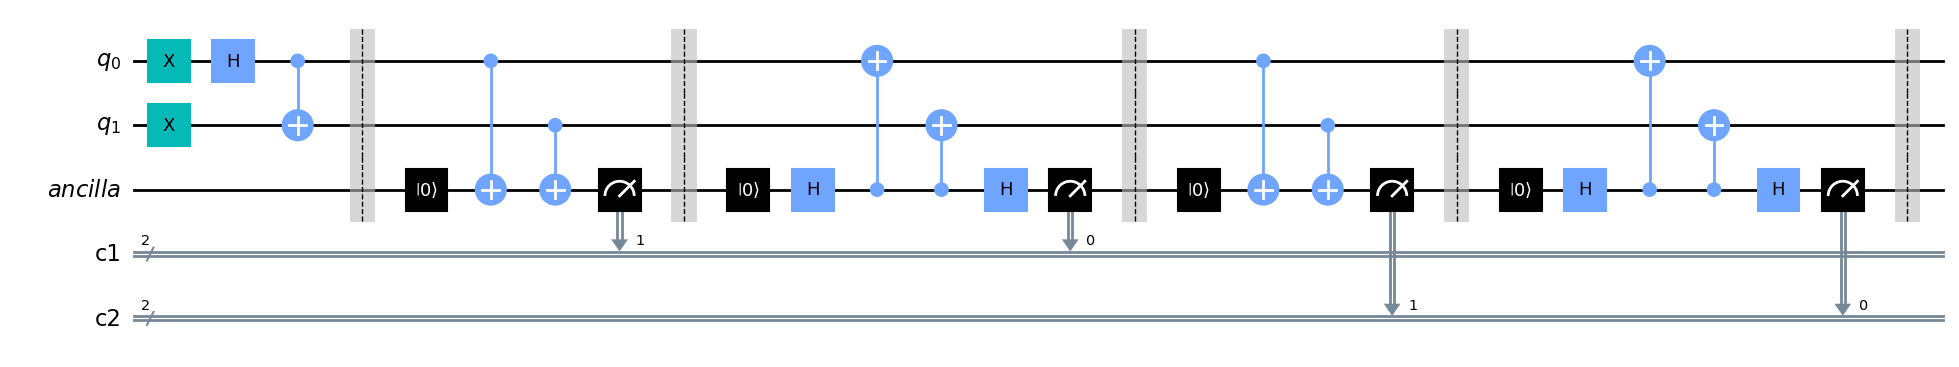

In [4]:
import itertools
for q0_gate, q1_gate in itertools.product(["i", "x"], repeat=2):  
    test_circ = QuantumCircuit(qr, an, *measurements)
    
    # Set up our Bell "generator" states
    getattr(test_circ, q0_gate)(0) #i.e. test_circ.i(0) or test_circ.x(0)
    getattr(test_circ, q1_gate)(1) #i.e. test_circ.i(1) or test_circ.x(1)
    
    # Create Bell state
    test_circ.h(0)
    test_circ.cx(0, 1)
    test_circ.barrier()

    test_circ = test_circ.compose(circ)
    print("Bell state %s%s:" % (q0_gate, q1_gate), execute(test_circ, Aer.get_backend('qasm_simulator'), shots=1).result().get_counts())
# Final Circuit Example
test_circ.draw(output='mpl', fold=35)

Even though our projective measurement is only on the ancilla qubit, all of our qubits are entangled through the stabilizer measurement process. Thus, the ancilla measurement *does* induce back-action on our actual qubit. For example, let's run the circuit on the $|00\rangle$ state, which is **not** a mutual eigenstate of the stabilizers:

In [5]:
execute(circ, Aer.get_backend('qasm_simulator')).result().get_counts()

/var/folders/k3/27w60qks2nn1dv0q05k_30z40000gn/T/ipykernel_21077/751475110.py:1: DeprecationWarning: The function ``qiskit.execute_function.execute()`` is deprecated as of qiskit 0.46.0. It will be removed in the Qiskit 1.0 release. This function combines ``transpile`` and ``backend.run``, which is covered by ``Sampler`` :mod:`~qiskit.primitives`. Alternatively, you can also run :func:`.transpile` followed by ``backend.run()``.
  execute(circ, Aer.get_backend('qasm_simulator')).result().get_counts()


{'01 01': 477, '00 00': 547}

Roughly half of the time we get `00 00`, and the other half `01 01`. If you go through the circuit, it's straightforward to verify that the first $XX$ measurement will project $|00\rangle$ into either the $|00\rangle$ + $|11\rangle$ or $|00\rangle$ - $|11\rangle$ Bell state (and their respective stabilizer eigenvalues).

In the absence of errors, subsequent measurements of the eigenvalue after the first stabilizer measurement will remain the same! This is known as the *quiescent state* of the code, and is an important part of the initialization process for surface codes.

## Toric Code to Surface Code
Korotkov’s law:  “In quantum mechanics you don’t see what you get, you get what you see.”

See James Wooten's [Decodoku toric code posts](http://decodoku.blogspot.com/2016/03/6-toric-code.html) for a great introduction to the intuition.

<p align="center">
<img width="800" alt="toric-code" src="https://user-images.githubusercontent.com/293681/98292863-6c19ca00-1f7b-11eb-85d5-c52ea6518e50.png">
</p>

## d=3 Surface Code with 17 Qubits

Following [2], we can generalize this into a d=3 rotated surface code with 9 data qubits and 8 ancillas. Please see the reference for details about how the circuit is constructed, including a subtlety with the direction of stabilzer measurements in each cell.

<p align="center">
<img width="800" alt="syndrome-measurement" src="https://user-images.githubusercontent.com/293681/98292541-dc741b80-1f7a-11eb-9e37-19333f821ee0.png">
<img width="400" alt="d-3-code-lattice" src="https://user-images.githubusercontent.com/293681/98292642-04637f00-1f7b-11eb-9924-8a02f512d65c.jpeg">
</p>

[2] Tomita, Y. & Svore, K. M. Low-distance surface codes under realistic quantum noise. Phys. Rev. A 90, 062320 (2014).

In [6]:
# [circ.x(i) for i in data]
def stabilize(circ, i):
    # Top left
    circ.h(mx[0])
    circ.cx(mx[0], data[1])
    circ.cx(mx[0], data[0])
    circ.h(mx[0])
    circ.cx(data[1], mz[0])
    circ.cx(data[4], mz[0])
    circ.cx(data[0], mz[0])
    circ.cx(data[3], mz[0])
    circ.barrier()
    
    # Top right
    circ.h(mx[1])
    circ.cx(mx[1], data[2])
    circ.cx(mx[1], data[1])
    circ.cx(mx[1], data[5])
    circ.cx(mx[1], data[4])
    circ.h(mx[1])
    circ.cx(data[2],mz[1])
    circ.cx(data[5],mz[1])
    circ.barrier()
    
    # Bottom left
    circ.cx(data[3], mz[2])
    circ.cx(data[6], mz[2])
    circ.h(mx[2])
    circ.cx(mx[2], data[4])
    circ.cx(mx[2], data[3])
    circ.cx(mx[2], data[7])
    circ.cx(mx[2], data[6])
    circ.h(mx[2])
    circ.barrier()

    # Bottom right
    circ.h(mx[3])
    circ.cx(mx[3], data[8])
    circ.cx(mx[3], data[7])
    circ.h(mx[3])
    circ.cx(data[5], mz[3])
    circ.cx(data[8], mz[3])
    circ.cx(data[4], mz[3])
    circ.cx(data[7], mz[3])
    circ.barrier()
    
    circ.measure(mz, measurements[i][0:4])
    circ.measure(mx, measurements[i][4:8])
    circ.reset(mz)
    circ.reset(mx)
    circ.barrier()

In [7]:
data = QuantumRegister(9, name='data')
mx = QuantumRegister(4, name='mx')
mz = QuantumRegister(4, name='mz')

rounds=1  # The actual number of rounds will always be more than 1, since the first round creates the quiescent state
measurements = [ClassicalRegister(8, name="c{}".format(i+1)) for i in range(rounds + 1)]
logical = QuantumRegister(1, name="logical")

base_circ = QuantumCircuit(data, mz, mx, *measurements, logical)

def get_stabilized_circ(base_circuit, rounds):
    circ = base_circuit.copy()
    for i in range(rounds + 1):
        stabilize(circ, i)
    return circ

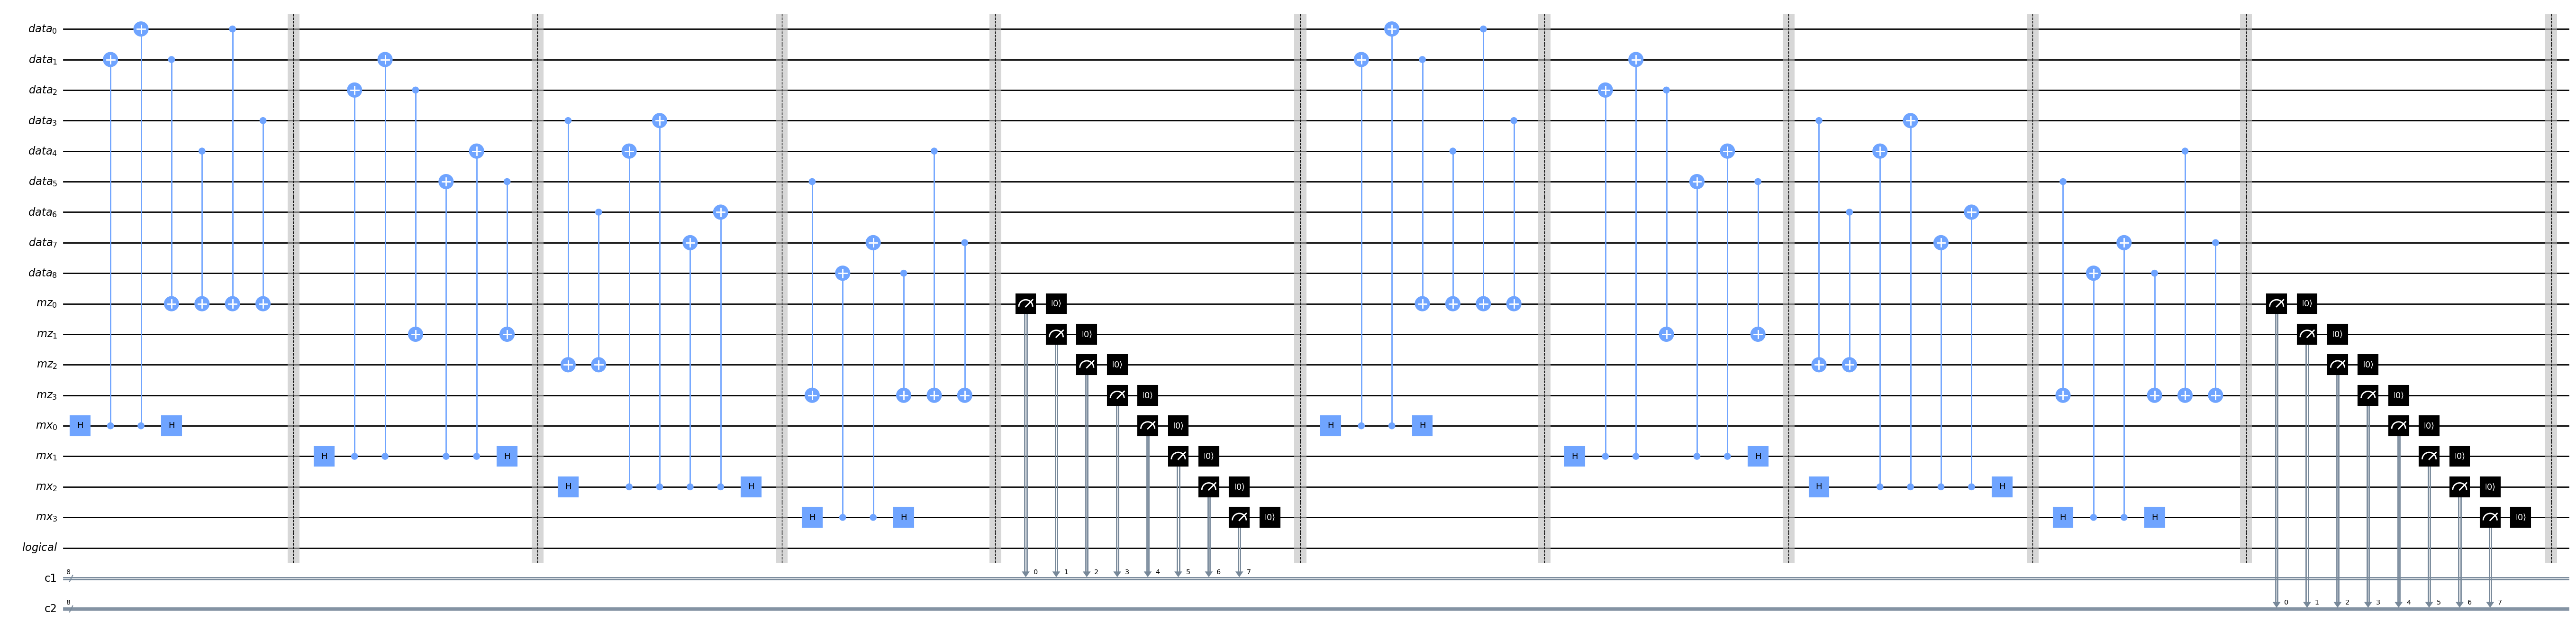

In [8]:
circ = get_stabilized_circ(base_circ, rounds)
circ.draw(output='mpl', fold=150)

### "Circuit generator" from our library

Works for arbitrary d (still odd, of course)! We basically iterate over each "syndrome face" and run the X or Z entanglement. Take a look at the code for more details, including the messy calculations for the lattice locations.

In [9]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [15]:
from qtcodes import XXZZQubit
from qiskit import QuantumCircuit, execute, QuantumRegister, ClassicalRegister, Aer
import matplotlib.pyplot as plt

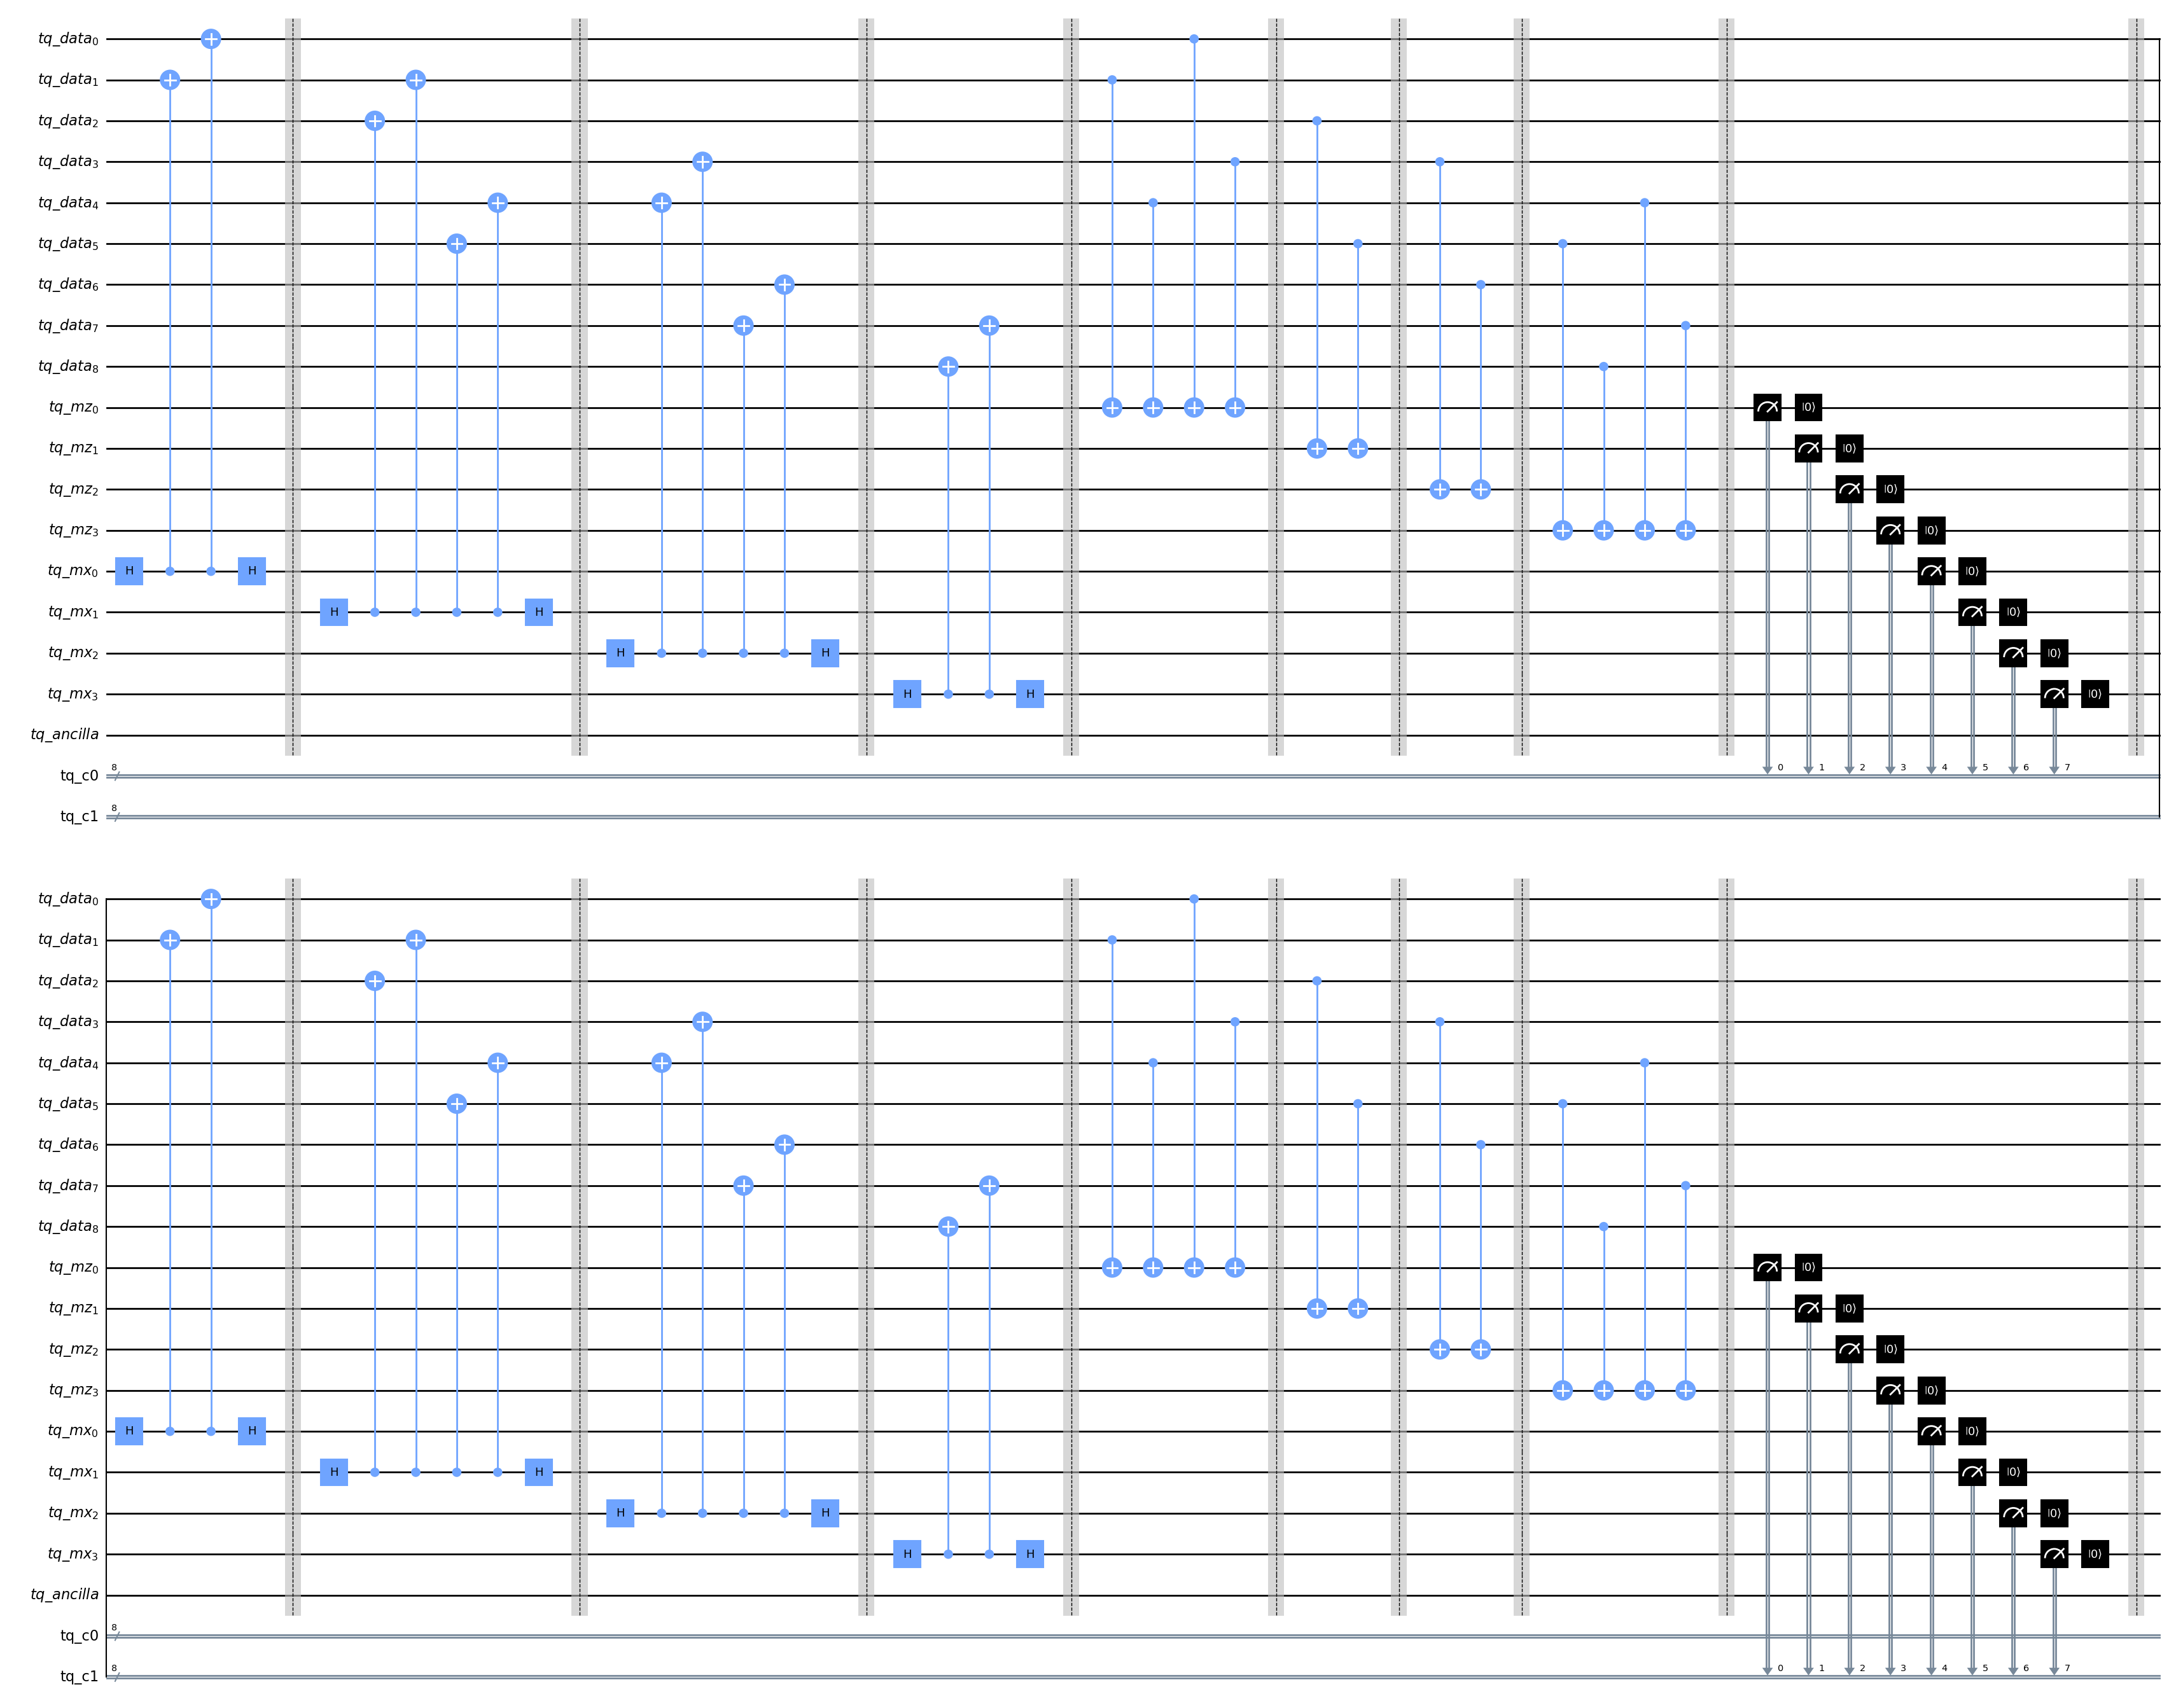

In [16]:
qubit = XXZZQubit() #d=3 default
# print(qubit)
qubit.stabilize()
qubit.stabilize()
qubit.draw(output='mpl', fold=50)

### Results Structure

1. **`aer_simulator`:** Results obtained from running the quantum circuit on a simulator backend provided by Qiskit. The simulator is used to model the behavior of a quantum circuit in an ideal or near-ideal environment, without the noise and errors that typically affect real quantum hardware.

2. **`ibm_brisbane`:** These results are from a real quantum processor located in Brisbane. Real hardware results are often influenced by noise, decoherence, and other quantum errors that do not affect simulated results.

3. **`ibm_kyiv`:** Similar to `ibm_brisbane`, these results come from another real quantum processor, but located in Kyiv, offering a different physical environment and potentially different error characteristics.

Each backend contains a dictionary where the keys are strings representing the measurement outcomes (bitstrings) of the quantum circuit, and the values are the counts indicating how many times each specific bitstring was observed.

The format of the bitstrings typically represents the outcomes of stabilizer measurements across multiple rounds of a quantum error correction protocol. The leading bit (before the space) often represents the final logical measurement outcome, while the subsequent groups of bits represent the results from individual rounds of syndrome measurements, where stabilizers like \(XXXX\) and \(ZZZZ\) are checked.

With the readout, the output format is:
$$\underbrace{L}_\text{Z Readout}~\underbrace{X_3X_2X_1X_0Z_3Z_2Z_1Z_0}_\text{Round 2} \quad \underbrace{X_3X_2X_1X_0Z_3Z_2Z_1Z_0}_\text{Round 1} \quad \underbrace{X_3X_2X_1X_0Z_3Z_2Z_1Z_0}_\text{Round 0}$$

### Summary of the Actual Results:

1. **`aer_simulator` Results:**
   - The results from the simulator show relatively stable and consistent measurement outcomes. Each unique bitstring has been observed multiple times (ranging from 44 to 77 counts), indicating the stability and consistency expected in a noise-free or low-noise environment.

2. **`ibm_brisbane` Results:**
   - The results from the `ibm_brisbane` backend show a significant amount of variability. Each bitstring is observed exactly once, reflecting the higher noise levels and potential errors associated with real quantum hardware. This suggests that the circuit produces a wide range of outcomes due to quantum errors or decoherence during the computation.

3. **`ibm_kyiv` Results:**
   - Similar to the `ibm_brisbane` results, the `ibm_kyiv` results also show each bitstring observed only once. This indicates similar levels of variability and noise. The results reflect the challenges in running quantum circuits on real hardware, where environmental factors, hardware imperfections, and noise lead to a broader distribution of measurement outcomes.

### Conclusion:
The data reveals stark differences between the simulated and real hardware environments. The simulator produces stable and repeated results, while the real hardware shows a highly varied outcome distribution, indicative of the errors and noise inherent in current quantum technology. Understanding these differences is crucial for refining quantum error correction techniques and improving the fidelity of quantum computations on real hardware.

Just like before, the $XXXX$ measurements will project our starting state into a quiescent state. Similarly, the $ZZZZ$ measurement doesn't do anything here, since both the starting state and the quiescent states are already Z-eigenstates.

We make four different $XXXX$ measurements, and each has two eigenvalues, so in this case there are $2^4 = 16$ possible combinations of syndrome measurements.

We can run this on the simulator and confirm. We see 3 groups of 8 bits, which are the syndrome measurement rounds. These are stable, and the first 4 bits permute through the 16 possible $XXXX$ syndromes. The output format is:

$$\underbrace{X_3X_2X_1X_0Z_3Z_2Z_1Z_0}_\text{Round 1} \quad \underbrace{X_3X_2X_1X_0Z_3Z_2Z_1Z_0}_\text{Round 0}$$

In [17]:
execute(qubit.circ, Aer.get_backend('qasm_simulator')).result().get_counts()

/var/folders/k3/27w60qks2nn1dv0q05k_30z40000gn/T/ipykernel_21077/3086871384.py:1: DeprecationWarning: The function ``qiskit.execute_function.execute()`` is deprecated as of qiskit 0.46.0. It will be removed in the Qiskit 1.0 release. This function combines ``transpile`` and ``backend.run``, which is covered by ``Sampler`` :mod:`~qiskit.primitives`. Alternatively, you can also run :func:`.transpile` followed by ``backend.run()``.
  execute(qubit.circ, Aer.get_backend('qasm_simulator')).result().get_counts()


{'11100000 11100000': 75,
 '01000000 01000000': 71,
 '00000000 00000000': 59,
 '11010000 11010000': 63,
 '10010000 10010000': 57,
 '11000000 11000000': 59,
 '01010000 01010000': 67,
 '11110000 11110000': 70,
 '10000000 10000000': 61,
 '00110000 00110000': 73,
 '01100000 01100000': 60,
 '10110000 10110000': 61,
 '00010000 00010000': 64,
 '10100000 10100000': 65,
 '00100000 00100000': 62,
 '01110000 01110000': 57}

From Decodoku posts by James Wooten:

http://decodoku.blogspot.com/2016/03/6-toric-code-part-2.html

<p align="center">
</p>

In our circuit, the Z-operator can be picked as any row of data qubits. We choose the top row:

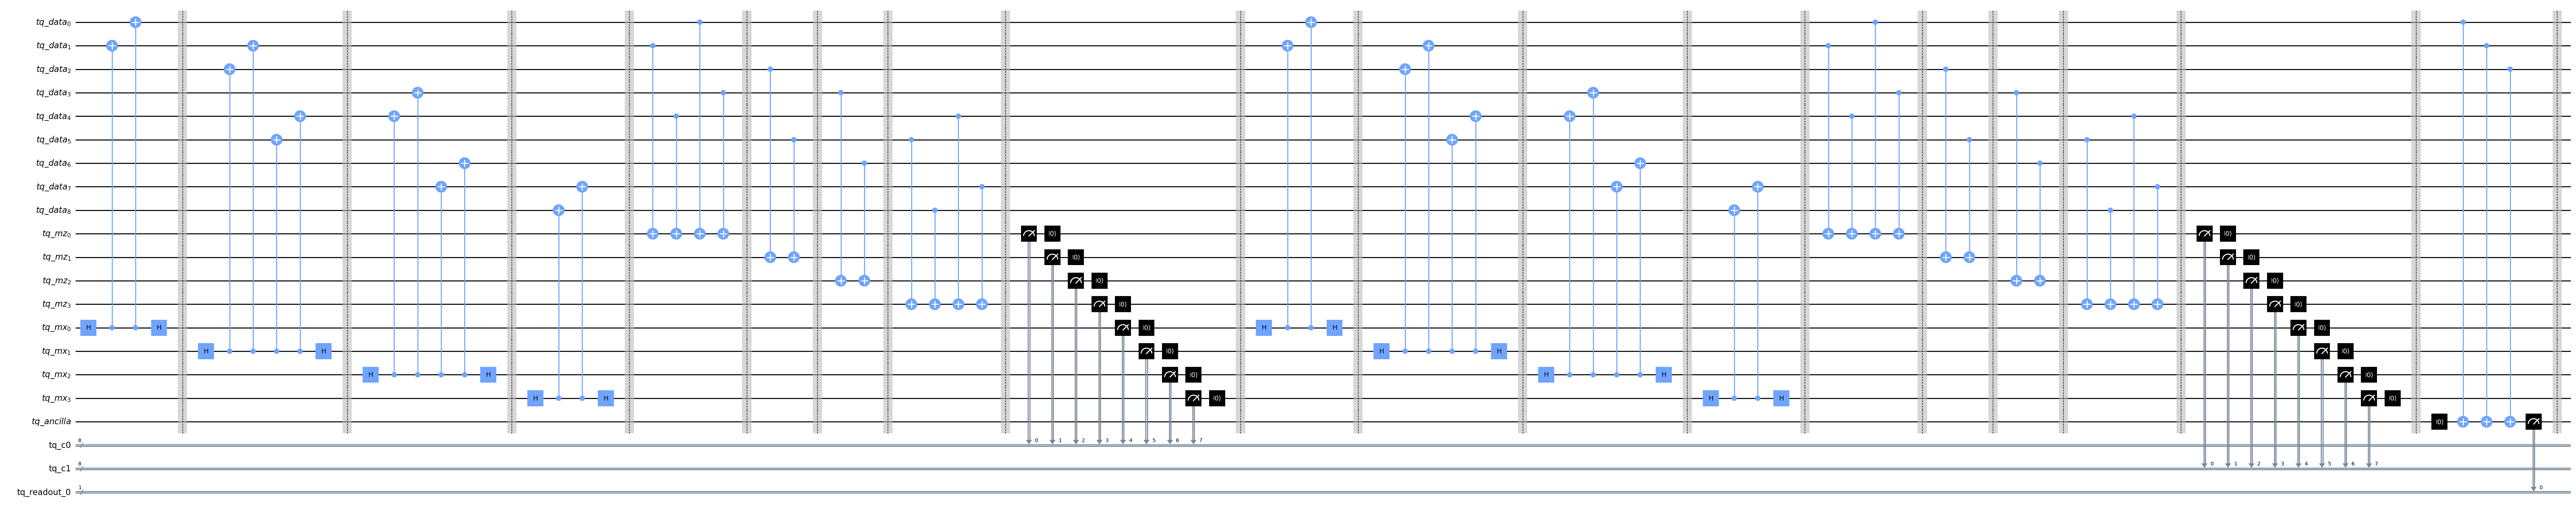

In [18]:
qubit.readout_z()
qubit.draw(output='mpl', fold=150)

With the readout, the output format is:
$$\underbrace{L}_\text{Z Readout}~\underbrace{X_3X_2X_1X_0Z_3Z_2Z_1Z_0}_\text{Round 1} \quad \underbrace{X_3X_2X_1X_0Z_3Z_2Z_1Z_0}_\text{Round 0}$$

In [19]:
execute(qubit.circ, Aer.get_backend('qasm_simulator')).result().get_counts()

/var/folders/k3/27w60qks2nn1dv0q05k_30z40000gn/T/ipykernel_21077/3086871384.py:1: DeprecationWarning: The function ``qiskit.execute_function.execute()`` is deprecated as of qiskit 0.46.0. It will be removed in the Qiskit 1.0 release. This function combines ``transpile`` and ``backend.run``, which is covered by ``Sampler`` :mod:`~qiskit.primitives`. Alternatively, you can also run :func:`.transpile` followed by ``backend.run()``.
  execute(qubit.circ, Aer.get_backend('qasm_simulator')).result().get_counts()


{'0 00010000 00010000': 72,
 '0 10010000 10010000': 59,
 '0 11100000 11100000': 66,
 '0 00110000 00110000': 67,
 '0 11010000 11010000': 45,
 '0 11000000 11000000': 68,
 '0 01010000 01010000': 58,
 '0 10100000 10100000': 67,
 '0 00100000 00100000': 50,
 '0 01000000 01000000': 70,
 '0 00000000 00000000': 61,
 '0 01100000 01100000': 73,
 '0 10000000 10000000': 76,
 '0 11110000 11110000': 75,
 '0 01110000 01110000': 60,
 '0 10110000 10110000': 57}

Applying the X operator, we can get a $|1_L\rangle$ state:

In [111]:
def get_exec_data(qubit, iters):
    mapped_results = {}

    for _ in range(iters):
        # Execute the circuit and get the results
        raw_results = execute(qubit.circ, Aer.get_backend('qasm_simulator')).result().get_counts()

        for key, value in raw_results.items():
            parts = key.split()
            first_col, middle_col = int(parts[0]), parts[1]

            if middle_col not in mapped_results:
                mapped_results[middle_col] = []

            # Append to end of existing entry pair
            syn_data = mapped_results[middle_col]
            if syn_data and len(syn_data[-1]) % 2 and first_col != syn_data[-1][0][0]:
                syn_data[-1].append((first_col, value))
            # Create new entry 
            else:
                syn_data.append([(first_col, value)])
    return mapped_results

In [112]:
qubit1 = XXZZQubit({'d':3})
qubit1.stabilize()
qubit1.stabilize()
qubit1.x()
qubit1.stabilize()
qubit1.readout_z() # includes leftmost "result" bit

#execute(qubit1.circ, Aer.get_backend('qasm_simulator')).result().get_counts()
get_exec_data(qubit1, 4)

/var/folders/k3/27w60qks2nn1dv0q05k_30z40000gn/T/ipykernel_21077/432867926.py:6: DeprecationWarning: The function ``qiskit.execute_function.execute()`` is deprecated as of qiskit 0.46.0. It will be removed in the Qiskit 1.0 release. This function combines ``transpile`` and ``backend.run``, which is covered by ``Sampler`` :mod:`~qiskit.primitives`. Alternatively, you can also run :func:`.transpile` followed by ``backend.run()``.
  raw_results = execute(qubit.circ, Aer.get_backend('qasm_simulator')).result().get_counts()


{'00010000': [[(1, 48)], [(1, 63)], [(1, 70)], [(1, 79)]],
 '10000000': [[(1, 59)], [(1, 69)], [(1, 57)], [(1, 70)]],
 '00110000': [[(1, 54)], [(1, 65)], [(1, 75)], [(1, 75)]],
 '10100000': [[(1, 48)], [(1, 71)], [(1, 60)], [(1, 59)]],
 '01010000': [[(1, 79)], [(1, 62)], [(1, 70)], [(1, 90)]],
 '10010000': [[(1, 66)], [(1, 54)], [(1, 59)], [(1, 57)]],
 '10110000': [[(1, 60)], [(1, 71)], [(1, 66)], [(1, 52)]],
 '01100000': [[(1, 77)], [(1, 55)], [(1, 69)], [(1, 69)]],
 '00000000': [[(1, 65)], [(1, 69)], [(1, 62)], [(1, 69)]],
 '11110000': [[(1, 72)], [(1, 63)], [(1, 71)], [(1, 53)]],
 '11010000': [[(1, 73)], [(1, 65)], [(1, 66)], [(1, 55)]],
 '11000000': [[(1, 70)], [(1, 71)], [(1, 59)], [(1, 65)]],
 '01110000': [[(1, 61)], [(1, 56)], [(1, 61)], [(1, 58)]],
 '00100000': [[(1, 74)], [(1, 59)], [(1, 62)], [(1, 65)]],
 '11100000': [[(1, 59)], [(1, 57)], [(1, 58)], [(1, 48)]],
 '01000000': [[(1, 59)], [(1, 74)], [(1, 59)], [(1, 60)]]}

If we initialize the circuit with $|+\rangle$ data qubits, we get a logical $|+\rangle$ state:

In [110]:
qubit2 = XXZZQubit({'d':3})
qubit2.stabilize()
qubit2.stabilize()
qubit2.x()
qubit2.stabilize()
qubit2.readout_x() 

get_exec_data(qubit2, 4)

/var/folders/k3/27w60qks2nn1dv0q05k_30z40000gn/T/ipykernel_21077/4182449986.py:6: DeprecationWarning: The function ``qiskit.execute_function.execute()`` is deprecated as of qiskit 0.46.0. It will be removed in the Qiskit 1.0 release. This function combines ``transpile`` and ``backend.run``, which is covered by ``Sampler`` :mod:`~qiskit.primitives`. Alternatively, you can also run :func:`.transpile` followed by ``backend.run()``.
  raw_results = execute(qubit.circ, Aer.get_backend('qasm_simulator')).result().get_counts()


{'00000000': [[(1, 18), (0, 30)],
  [(0, 29), (1, 30)],
  [(0, 30), (1, 24)],
  [(0, 34), (1, 35)]],
 '10010000': [[(1, 19), (0, 40)],
  [(1, 36), (0, 32)],
  [(1, 38), (0, 29)],
  [(0, 33), (1, 35)]],
 '01000000': [[(1, 25), (0, 47)],
  [(1, 32), (0, 33)],
  [(0, 25), (1, 29)],
  [(1, 24), (0, 34)]],
 '01110000': [[(1, 41), (0, 37)],
  [(0, 27), (1, 39)],
  [(1, 31), (0, 29)],
  [(0, 35), (1, 30)]],
 '11100000': [[(0, 35), (1, 37)],
  [(0, 28), (1, 36)],
  [(1, 33), (0, 27)],
  [(1, 36), (0, 33)]],
 '01100000': [[(1, 32), (0, 32)],
  [(1, 30), (0, 25)],
  [(1, 37), (0, 31)],
  [(0, 34), (1, 30)]],
 '00100000': [[(1, 34), (0, 30)],
  [(1, 28), (0, 37)],
  [(0, 27), (1, 33)],
  [(1, 39), (0, 32)]],
 '11000000': [[(1, 36), (0, 28)],
  [(0, 28), (1, 29)],
  [(1, 19), (0, 35)],
  [(1, 38), (0, 30)]],
 '11010000': [[(1, 37), (0, 31)],
  [(1, 34), (0, 42)],
  [(1, 31), (0, 32)],
  [(1, 25), (0, 32)]],
 '10100000': [[(0, 31), (1, 17)],
  [(0, 36), (1, 31)],
  [(1, 37), (0, 42)],
  [(1, 34), (

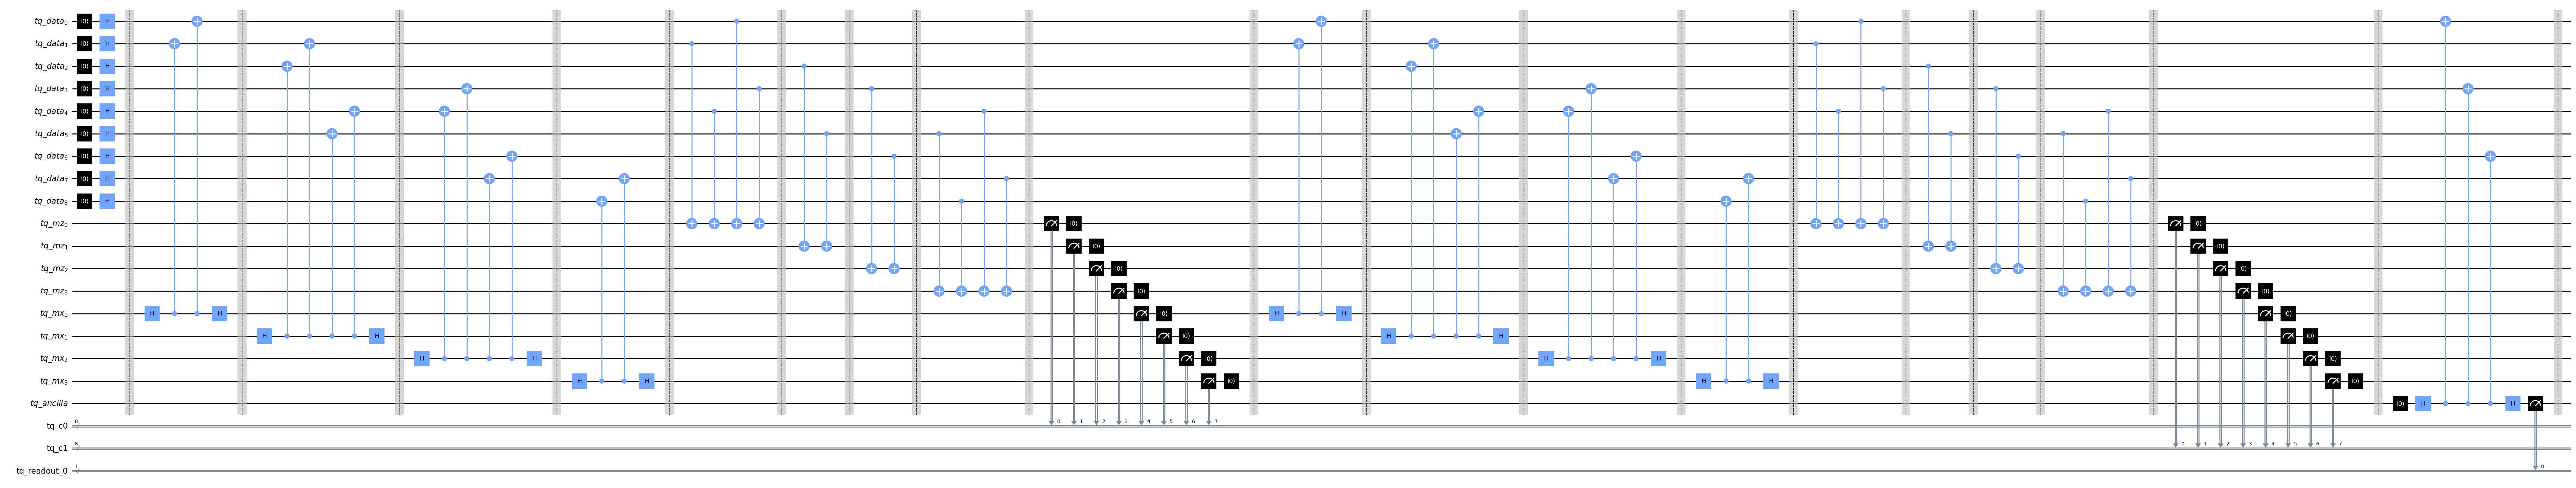

In [22]:
qubit = XXZZQubit({'d':3})
qubit.reset_x()
qubit.stabilize()
qubit.stabilize()
qubit.readout_x()  # Note that we need to readout X now instead of Z
qubit.draw(output='mpl', fold=150)

In [23]:
execute(qubit.circ, Aer.get_backend('qasm_simulator')).result().get_counts()

/var/folders/k3/27w60qks2nn1dv0q05k_30z40000gn/T/ipykernel_21077/3086871384.py:1: DeprecationWarning: The function ``qiskit.execute_function.execute()`` is deprecated as of qiskit 0.46.0. It will be removed in the Qiskit 1.0 release. This function combines ``transpile`` and ``backend.run``, which is covered by ``Sampler`` :mod:`~qiskit.primitives`. Alternatively, you can also run :func:`.transpile` followed by ``backend.run()``.
  execute(qubit.circ, Aer.get_backend('qasm_simulator')).result().get_counts()


{'0 00000111 00000111': 60,
 '0 00000110 00000110': 59,
 '0 00001101 00001101': 58,
 '0 00000011 00000011': 60,
 '0 00001011 00001011': 60,
 '0 00000101 00000101': 58,
 '0 00000001 00000001': 66,
 '0 00001001 00001001': 76,
 '0 00001100 00001100': 70,
 '0 00001111 00001111': 63,
 '0 00000010 00000010': 60,
 '0 00000100 00000100': 53,
 '0 00001010 00001010': 71,
 '0 00001000 00001000': 63,
 '0 00001110 00001110': 73,
 '0 00000000 00000000': 74}

The logical-Z operator will flip this to $|-\rangle$

In [26]:
qubit = XXZZQubit({'d':3})
qubit.reset_x()
qubit.stabilize()

qubit.z()

qubit.stabilize()
qubit.readout_x() 

execute(qubit.circ, Aer.get_backend('qasm_simulator')).result().get_counts()

/var/folders/k3/27w60qks2nn1dv0q05k_30z40000gn/T/ipykernel_21077/2429118871.py:10: DeprecationWarning: The function ``qiskit.execute_function.execute()`` is deprecated as of qiskit 0.46.0. It will be removed in the Qiskit 1.0 release. This function combines ``transpile`` and ``backend.run``, which is covered by ``Sampler`` :mod:`~qiskit.primitives`. Alternatively, you can also run :func:`.transpile` followed by ``backend.run()``.
  execute(qubit.circ, Aer.get_backend('qasm_simulator')).result().get_counts()


{'1 00000100 00000100': 63,
 '1 00001100 00001100': 56,
 '1 00001001 00001001': 53,
 '1 00000101 00000101': 56,
 '1 00000011 00000011': 64,
 '1 00001011 00001011': 63,
 '1 00001000 00001000': 63,
 '1 00001010 00001010': 68,
 '1 00000111 00000111': 70,
 '1 00001110 00001110': 64,
 '1 00001101 00001101': 71,
 '1 00000000 00000000': 63,
 '1 00001111 00001111': 62,
 '1 00000010 00000010': 78,
 '1 00000110 00000110': 57,
 '1 00000001 00000001': 73}

### Rectangular lattices are supported

Instead of passing a single integer when initializing our qubit we can pass a tuple instead, which will result in a rectangularly shaped lattice.

In [113]:
qubit = XXZZQubit({'d':(3, 5)})
qubit.stabilize()
qubit.stabilize()
qubit.x()
qubit.stabilize()
qubit.readout_z()

execute(qubit.circ, Aer.get_backend('qasm_simulator')).result().get_counts()

/var/folders/k3/27w60qks2nn1dv0q05k_30z40000gn/T/ipykernel_21077/1245616384.py:8: DeprecationWarning: The function ``qiskit.execute_function.execute()`` is deprecated as of qiskit 0.46.0. It will be removed in the Qiskit 1.0 release. This function combines ``transpile`` and ``backend.run``, which is covered by ``Sampler`` :mod:`~qiskit.primitives`. Alternatively, you can also run :func:`.transpile` followed by ``backend.run()``.
  execute(qubit.circ, Aer.get_backend('qasm_simulator')).result().get_counts()


TranspilerError: 'Number of qubits (30) in circuit-313 is greater than maximum (29) in the coupling_map'

### For fun, the d=5 surface code

In [ ]:
qubit = XXZZQubit({'d':5})
qubit.stabilize()
qubit.draw(output='mpl', fold=170)

We can test the effect of errors. We insert X-flips at qubits 6 and 9. The output syndrome has the format:

$$\underbrace{L}_\text{Z Readout}~\underbrace{X_NX_{N-1}...X_0Z_NZ_{N-1}...Z_0}_\text{Round 1} \quad \underbrace{X_NX_{N-1}...X_0Z_NZ_{N-1}...Z_0}_\text{Round 0}$$

We should get syndrome flips at $Z_0, Z_2, Z_4, Z_5$:
<p align="center">
<img width="500" alt="torus" src="https://user-images.githubusercontent.com/293681/98292078-1a247480-1f7a-11eb-90f3-822a55f1a8ff.jpg">
</p>

In [ ]:
qubit = XXZZQubit({'d':5})
qubit.stabilize()
qubit.circ.x(6)
qubit.circ.x(9)
qubit.stabilize()
qubit.readout_z()

In [ ]:
results = execute(qubit.circ, Aer.get_backend('qasm_simulator'), shots=1).result().get_counts()

In [ ]:
readout_string = list(results.keys())[0]
print(readout_string)
qubit.parse_readout(readout_string)

### Using lattice readout

We can also readout the lattice (i.e. measure each data qubit) along a specified axis to get BOTH a final syndrome measurement and a logical readout. 

Suppose we are trying to make a logical Z readout. In this case, we will measure each data qubit along the Z axis. This will allow us to extract a logical Z readout and a final set of Z syndrome measurements. 

However, we will not be able to extract a final set of X syndrome measurements. This is ok. When measuring logical Z readout, we only care about X flips on any data qubits, which are fully detected by the Z syndrome graph.

In [114]:
qubit = XXZZQubit({'d':5})
qubit.stabilize()
qubit.circ.x(0)
qubit.circ.z(0)
qubit.stabilize()
qubit.circ.x(0)
qubit.circ.z(0) #this will not be detected, but that's ok!
qubit.lattice_readout_z()

In [115]:
from qiskit.providers.aer import AerSimulator
backend = Aer.get_backend('qasm_simulator')
# backend = AerSimulator(method='matrix_product_state')
results = execute(qubit.circ, backend, shots=1).result().get_counts()
readout_string = list(results.keys())[0]
print("Readout String: ", readout_string)
logical_readout, syndromes = qubit.parse_readout(readout_string, "Z")
print("Logical Readout: ", logical_readout)
print("Syndromes: \n", syndromes)

/var/folders/k3/27w60qks2nn1dv0q05k_30z40000gn/T/ipykernel_21077/1804451450.py:1: DeprecationWarning: Importing from 'qiskit.providers.aer' is deprecated. Import from 'qiskit_aer' instead, which should work identically.
  from qiskit.providers.aer import AerSimulator
/var/folders/k3/27w60qks2nn1dv0q05k_30z40000gn/T/ipykernel_21077/1804451450.py:4: DeprecationWarning: The function ``qiskit.execute_function.execute()`` is deprecated as of qiskit 0.46.0. It will be removed in the Qiskit 1.0 release. This function combines ``transpile`` and ``backend.run``, which is covered by ``Sampler`` :mod:`~qiskit.primitives`. Alternatively, you can also run :func:`.transpile` followed by ``backend.run()``.
  results = execute(qubit.circ, backend, shots=1).result().get_counts()


TranspilerError: 'Number of qubits (50) in circuit-314 is greater than maximum (29) in the coupling_map'

First, notice that the first chunk of the readout string represents the result of a readout of all 25 data qubits.
As shown above, the 'Z' syndrome graph detects errors from both rounds, while the 'X' syndrome graph detects errors from just the first round as it does not pick up on the second Z data flip. Again, this is ok, since we are performing a logical Z readout!

Notice that the logical Z readout is affected by the x flip on the 0th data qubit. Fear not! This will be corrected by MWPM decoding. 